In [1]:
import json
import requests
import time
import traceback

In [2]:
# 約定情報
class Execution(object):
    def __init__(self, jsonobj=None):
        if jsonobj:
            self.id = jsonobj['id']
            self.side = jsonobj['side']
            self.price = jsonobj['price']
            self.size = jsonobj['size']
            self.timestamp = jsonobj['exec_date']

    def to_csv_line(self):
        line = '{},{},{},{},{}\n'
        line = line.format(self.id, self.side, self.price,
                           self.size, self.timestamp)
        return line

In [3]:
# bitFlyerのPublic APIを触るためのクラス
class PublicApi(object):

    API_URI = 'https://api.bitflyer.jp/v1/'

    def __init__(self, currency_pair):
        self.currency_pair = currency_pair

    def __get_request(self, endpoint, params=None):
        response = requests.get(endpoint, params=params)
        if response.status_code < 200 or response.status_code >= 300:
            raise Exception('Bad status code {}. Url={}. Body={}'.format(
                response.status_code,
                response.url,
                response.text))
        return response

    def get_executions(self, count=500, before=0, after=0):
        endpoint = PublicApi.API_URI + 'getexecutions'
        params = {
            'product_code': self.currency_pair,
            'count': count,
            'before': before
        }

        if after > 0: params['after'] = after
        response = self.__get_request(endpoint, params=params)
        results = response.json()
        executions = [Execution(x) for x in results]
        return executions

    def save_all_executions(self, csv_file, count=10000):
        """ Get all execution history from public api """
        with open(csv_file, 'w', encoding='utf-8') as f:
            latest = self.get_executions(count=1)
            before = latest[0].id + 1
            saved = 0

            f.write('id,side,price,size,timestamp\n')
            while before > 1:
                try:
                    executions = self.get_executions(before=before)
                    before = executions[-1].id
                    lines = [x.to_csv_line() for x in executions]
                    f.writelines(lines)
                    saved += len(executions)
                    time.sleep(0.12)
                except:
                    print('Failed to process executions. before={}'.format(before))
                    print(traceback.format_exc())

                if count and saved >= count:
                    break

In [4]:
# 直近1000件をダウンロード
public = PublicApi('BTC_JPY')
public.save_all_executions('./executions.csv', count=1000)

In [5]:
# CSVからロードしてくる
import pandas as pd
csv_file = './executions.csv'
df = pd.read_csv(csv_file, parse_dates=['timestamp'])
df.head()

,id,side,price,size,timestamp
0,102381859,SELL,1761254.0,1.174725,2017-12-29 06:46:48.763
1,102381856,SELL,1761254.0,0.001000,2017-12-29 06:46:48.467
2,102381853,SELL,1761254.0,0.012000,2017-12-29 06:46:48.217
3,102381851,BUY,1761400.0,0.010000,2017-12-29 06:46:47.843
4,102381847,SELL,1761254.0,0.005000,2017-12-29 06:46:47.593


In [6]:
# そのままグラフを書いてみる
df[['timestamp', 'price']].set_index('timestamp').plot(figsize=(18,9))

In [7]:
# ローソクチャートを書くために、タイムスタンプの秒以下を切り捨てる。
# ここを調整すると、任意の時間幅で集計できる。
df['timestamp'] = df['timestamp'].map(lambda x: x.replace(second=0, microsecond=0))
df.head()

,id,side,price,size,timestamp
0,102381859,SELL,1761254.0,1.174725,2017-12-29 06:46:00
1,102381856,SELL,1761254.0,0.001000,2017-12-29 06:46:00
2,102381853,SELL,1761254.0,0.012000,2017-12-29 06:46:00
3,102381851,BUY,1761400.0,0.010000,2017-12-29 06:46:00
4,102381847,SELL,1761254.0,0.005000,2017-12-29 06:46:00


In [8]:
# 1分毎の安値と高値(min, max)、始値と終値(first, last)、および取引量(size) を集計
summary = df[['timestamp', 'price']].groupby(['timestamp']).min().rename(columns={'price': 'min'})
summary = summary.merge(
    df[['timestamp', 'price']].groupby(['timestamp']).max().rename(columns={'price': 'max'}),
    left_index=True, right_index=True)
summary = summary.merge(
    df[['timestamp', 'price']].groupby(['timestamp']).first().rename(columns={'price': 'first'}),
    left_index=True, right_index=True)
summary = summary.merge(
    df[['timestamp', 'price']].groupby(['timestamp']).last().rename(columns={'price': 'last'}),
    left_index=True, right_index=True)
summary = summary.merge(
    df[['timestamp', 'size']].groupby(['timestamp']).sum(),
    left_index=True, right_index=True)
summary.head()

,min,max,first,last,size
timestamp,,,,,
2017-12-29 06:30:00,1762000.0,1762500.0,1762500.0,1762096.0,0.581000
2017-12-29 06:31:00,1761275.0,1762500.0,1761275.0,1762500.0,0.874121
2017-12-29 06:32:00,1758160.0,1761424.0,1760987.0,1761424.0,8.905689
2017-12-29 06:33:00,1755912.0,1760987.0,1758001.0,1760987.0,6.685753
2017-12-29 06:34:00,1755000.0,1758000.0,1756989.0,1756645.0,5.968796


Text(0,0.5,'Volume')

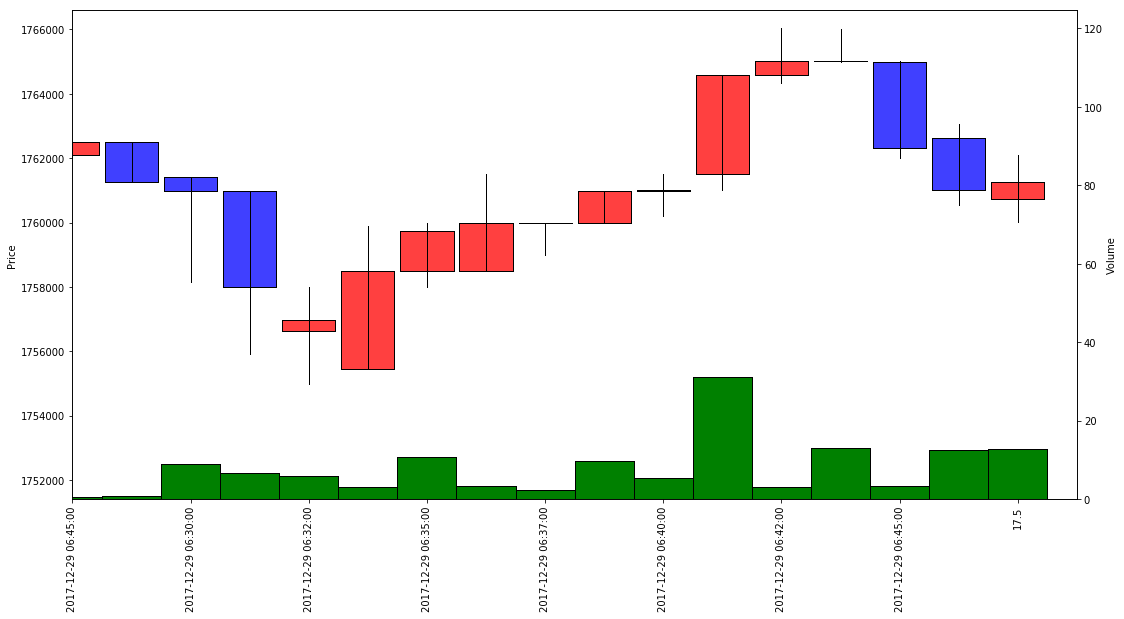

In [9]:
# 下記記事の通りにチャートを描画
# http://www.madopro.net/entry/CandleStickWithPython

import matplotlib.pyplot as plt
from matplotlib.finance import candlestick2_ohlc, volume_overlay

df2 = summary[-1000:]

# ローソク足をプロット
fig = plt.figure(figsize=(18, 9))
ax = plt.subplot(1, 1, 1)
candlestick2_ohlc(ax, df2["first"], df2["max"], df2["min"], df2["last"], width=0.9, colorup="b", colordown="r")
ax.set_xticklabels([(df2.index[int(x)] if x < df2.shape[0] else x) for x in ax.get_xticks()], rotation=90)
ax.set_xlim([0, df2.shape[0]])
ax.set_ylabel("Price")

# ローソク足を上側75%に収める
bottom, top = ax.get_ylim()
ax.set_ylim(bottom - (top - bottom) / 4, top)

# 出来高のチャートをプロット
ax2 = ax.twinx()
volume_overlay(ax2, df2["first"], df2["last"], df2["size"], width=1, colorup="g", colordown="g")
ax2.set_xlim([0, df2.shape[0]])

# 出来高チャートは下側25%に収める
ax2.set_ylim([0, df2["size"].max() * 4])
ax2.set_ylabel("Volume")